## **Task 1: Automatically crop out the part where the horse moves from left to right**

### Solution logic:


**1. Video Input and Initialization:**

- Open and read the video file frame by frame.
- Use a pre-trained object detection model (YOLO) to check if a horse is present in each frame and locate its bounding box.

**2. Motion Detection Using Background Subtraction:**

- Apply background subtraction to isolate moving objects (like a horse) from the background.
- Convert the results to a binary mask that highlights significant movements.

**3. Filtering and Contour Analysis:**

- Detect contours in the binary mask to identify areas of motion.
- Focus on larger contours to ensure only significant movements (e.g., a horse walking) are processed, filtering out minor or irrelevant changes.

**4. Object Tracking via Centroid Calculation:**

- Track the centroid of detected motion areas within the horse’s bounding box.
- Compare the current centroid position to the previous frame’s centroid to determine the direction of motion (e.g., moving left or right).

**5. Motion-based Video Recording:**

- Start recording frames if the horse is detected and actively moving.
- Stop recording when no motion is detected for a period, ensuring only relevant parts of the video are saved.

**6. Visual Feedback and Output:**

- Provide visual cues by marking the centroid on the video and displaying the direction of motion (e.g., “Moving right”).
- Save the processed frames to create a cropped video that only captures moments when the horse is actively moving.


In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

--2024-10-14 13:53:33--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  15.4MB/s    in 16s     

2024-10-14 13:53:50 (14.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-10-14 13:53:50--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2

In [ ]:
import cv2
import numpy as np

# Load YOLO model and COCO labels
def load_yolo_model():
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
    layer_names = net.getLayerNames()
    # Get the output layer indices as a NumPy array
    output_layers_indices = net.getUnconnectedOutLayers()
    # Access the layer names using the indices directly
    output_layers = [layer_names[i - 1] for i in output_layers_indices]
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
    return net, output_layers, classes

def detect_horse(frame, net, output_layers, classes):
    height, width, channels = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    horse_detected = False
    horse_box = None

    # Information to capture
    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # Only consider strong detections
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                # Only care if the object is a horse (class id for horse in COCO dataset is 17)
                if class_id == 17:  # Horse ID in COCO
                    horse_detected = True
                    horse_box = (x, y, w, h)
                    # cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    break

    return horse_detected, horse_box

In [ ]:
def detect_horse_motion_and_crop(video_path, output_path):
    net, output_layers, classes = load_yolo_model()

    cap = cv2.VideoCapture(video_path)
    fgbg = cv2.createBackgroundSubtractorMOG2()
    frames_with_motion = []

    # Set up the video writer
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (frame_width, frame_height))

    recording = False
    horse_roi = None
    total_frames = 0
    horse_detected_frames = 0
    prev_centroid = None  # Store previous centroid to detect direction

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        total_frames += 1

        # Detect if a horse is in the frame
        horse_detected, horse_box = detect_horse(frame, net, output_layers, classes)

        if horse_detected:
            # Apply background subtraction for motion detection
            fgmask = fgbg.apply(frame)
            th = cv2.threshold(fgmask, 200, 255, cv2.THRESH_BINARY)[1]
            contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            horse_motion_detected = False
            current_centroid = None  # Track the current centroid

            for contour in contours:
                area = cv2.contourArea(contour)
                if area > 100:  # Consider only large movements
                    x, y, w, h = cv2.boundingRect(contour)

                    # Check if the detected motion is within the horse's bounding box
                    if horse_box and (x >= horse_box[0] - 50 and x + w <= horse_box[0] + horse_box[2] + 50):
                        horse_motion_detected = True
                        # cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)

                        # Calculate the centroid of the motion (center of the bounding box)
                        current_centroid = (x + w // 2, y + h // 2)
                        cv2.circle(frame, current_centroid, 5, (0, 255, 0), -1)  # Visualize the centroid

            if horse_motion_detected and current_centroid is not None:
                # Compare the current centroid with the previous one to determine direction
                if prev_centroid is not None:
                    if current_centroid[0] > prev_centroid[0]:
                        motion_direction = "Moving right (positive direction)"
                        frames_with_motion.append(frame)
                        horse_detected_frames += 1
                    elif current_centroid[0] < prev_centroid[0]:
                        motion_direction = "Moving left (negative direction)"
                    else:
                        motion_direction = "Stationary (no significant horizontal movement)"

                    # Display the detected direction on the frame
                    cv2.putText(frame, motion_direction, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
                    print(motion_direction)

                # Update the previous centroid
                prev_centroid = current_centroid

                frames_with_motion.append(frame)
                # horse_detected_frames += 1
                if not recording:
                    print("Horse detected and moving, starting to record...")
                    recording = True

        if not horse_detected or not horse_motion_detected:
            if recording and horse_detected_frames > 0:
                print("No horse motion detected, stopping recording.")
                recording = False
                break

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    for frame in frames_with_motion:
        out.write(frame)

    cap.release()
    out.release()
    print(f"Cropped video saved as {output_path}")




video_path = "/content/drive/MyDrive/test_video.mp4"
output_path = "cropped_horse_motion_pd_video_v2.mp4"
detect_horse_motion_and_crop(video_path, output_path)


Horse detected and moving, starting to record...
Moving right (positive direction)
Moving left (negative direction)
Moving left (negative direction)
Moving right (positive direction)
Moving left (negative direction)
Moving left (negative direction)
Moving right (positive direction)
Moving right (positive direction)
Moving left (negative direction)
Moving left (negative direction)
Moving left (negative direction)
Moving right (positive direction)
Moving left (negative direction)
Moving left (negative direction)
Moving left (negative direction)
Moving left (negative direction)
Moving right (positive direction)
Moving right (positive direction)
Moving left (negative direction)
Moving right (positive direction)
Moving right (positive direction)
Moving left (negative direction)
Moving left (negative direction)
Moving right (positive direction)
Moving right (positive direction)
Moving left (negative direction)
Moving left (negative direction)
Moving right (positive direction)
Moving left (ne

#### **Here's the link to the output video:**  https://drive.google.com/file/d/1WNacS8HFYsba9OqdYGEMfpCaQq9Teh8J/view?usp=drive_link

## **Task 2: Remove the background from the cropped video, isolating only the horse.**


Solution Logic:

1. **Load Model & Set Up Video:** Initialize the YOLOv8 segmentation model. Prepare input and output video streams.

2. **Frame Processing:** Read each video frame, run object detection, and extract masks specific to horses.

3. **Mask Application:** Resize, combine, and refine masks to isolate horses. Use these masks to filter out the background.

4. **Output:** Save the processed frames, creating a video with only the segmented horses.


In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load a YOLOv8 segmentation model (make sure to download weights if needed)
model = YOLO('yolov8x-seg.pt')

In [ ]:
# Load the image
image = cv2.imread('/content/horse_2.jpg')

# Run YOLOv8 Segmentation
results = model(image)

def seg_mask(image, results):
  # Parse the results
  segmentation_masks = results[0].masks.data.cpu().numpy()
  detections = results[0].boxes.data.cpu().numpy()

  # Filter masks to keep only horses (class index for 'horse' might need adjustment)
  # Assuming `results.names[17]` is horse, adjust based on your class indices
  horse_masks = []
  for det, mask in zip(detections, segmentation_masks):
      if int(det[5]) == 17:  # class index for 'horse'
          horse_masks.append(mask)

  # Adjust the mask to match the dimensions of final_mask
  final_mask = np.zeros(image.shape[:2], dtype=np.uint8)

  for mask in horse_masks:
      # Resize the mask to match the size of the original image
      mask_resized = cv2.resize(mask, (final_mask.shape[1], final_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

      # Ensure the mask is binary (0 or 1), if needed convert to binary by thresholding
      mask_binary = (mask_resized > 0.5).astype(np.uint8) * 255

      # Combine the masks
      final_mask = cv2.bitwise_or(final_mask, mask_binary)

  return final_mask





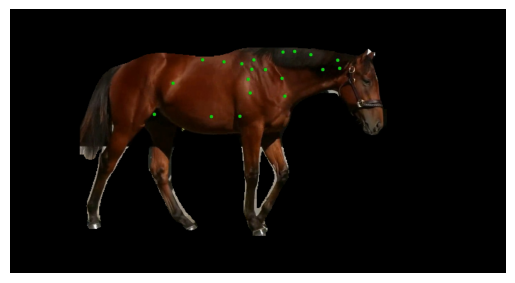

In [ ]:
# Apply the mask to the image
result = cv2.bitwise_and(image, image, mask=final_mask)

# Show the result
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [ ]:
import cv2
import torch
import numpy as np

def process_video(input_video_path, output_video_path, class_name='horse'):
    # Load YOLOv8 model
    model = YOLO('yolov8x-seg.pt')

    # Open the input video
    cap = cv2.VideoCapture(input_video_path)

    # Get the width, height, and frame rate of the video
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Define codec and create VideoWriter object for output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Run YOLOv8 on the frame
        results = model(frame)

        final_mask=seg_mask(frame, results)

        # Apply the final mask to remove the background
        result_frame = cv2.bitwise_and(frame, frame, mask=final_mask)

        # Write the processed frame to the output video
        out.write(result_frame)


    # Release resources
    cap.release()
    out.release()


In [ ]:
process_video('/content/drive/MyDrive/cropped_horse_motion_pd_video_2.mp4', 'isolated_horse.mp4')

#### **Link to the resulting video:** https://drive.google.com/file/d/1efcIQNmosAahI21kNypR_gsVcZeAq70R/view?usp=sharing

## **Task 3:  Crop the part where the horse moves towards the screen.**


Steps taken:

1. Fine-tune a Vision-Language Model (VLM), specifically CLIP, on a binary classification task to classify frames of horses as either:
- "not walking into the camera with its head and body straight" (indicating the horse is not moving towards the camera)
- "walking into the camera with its head and body straight" (indicating the horse is moving towards the camera)

2. Use the fine-tuned model to detect frames in the video where the horse is moving into the screen

3. Determine if there is a pattern where the bounding box sizes are increasing for frames that have been classified as moving closer to the screen.



### Fine-tuning

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, AdamW
from tqdm import tqdm

# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Define your dataset class
class HorseOrientationDataset(Dataset):
    def __init__(self, image_paths, labels, processor):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load and process image
        image = Image.open(self.image_paths[idx]).convert("RGB")
        text = self.labels[idx]

        # Preprocess inputs and ensure proper padding
        inputs = self.processor(text=text, images=image, return_tensors="pt", padding="max_length", truncation=True, max_length=77)

        # Remove the extra dimension for batching
        return {k: v.squeeze(0) for k, v in inputs.items()}

# Function to load images and labels from folders
def load_images_and_labels(base_dir):
    image_paths = []
    labels = []
    label_folders = {
        "not walking into the camera with its head and body straight": "frames_label_not",
        "walking into the camera with its head and body straight": "frames_label"
    }

    for label, folder in label_folders.items():
        folder_path = os.path.join(base_dir, folder)
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_paths.append(os.path.join(folder_path, filename))
                labels.append(label)

    return image_paths, labels

# Specify the base directory containing the labeled image folders
base_directory = "/content/drive/MyDrive/output"  # Replace with your folder path

# Load the dataset
image_paths, labels = load_images_and_labels(base_directory)

# Create dataset and dataloader
dataset = HorseOrientationDataset(image_paths, labels, processor)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Prepare for training
model.train()
optimizer = AdamW(model.parameters(), lr=5e-5)

# Fine-tuning loop
num_epochs = 6
for epoch in range(num_epochs):
    total_loss = 0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()

        # Move input tensors to GPU if available
        inputs = {k: v.to(model.device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**inputs)

        # Use the logits directly for calculating the loss
        logits_per_image = outputs.logits_per_image

        # Create labels tensor based on the current batch
        current_labels = [labels[i] for i in range(len(inputs['input_ids']))]  # Get labels for the current batch
        labels_tensor = torch.tensor([0 if label == "not walking into the camera with its head and body straight" else 1 for label in current_labels]).to(model.device)

        # Check shapes for debugging
        assert logits_per_image.shape[0] == labels_tensor.shape[0], "Shape mismatch: logits and labels must match in batch size."

        # Calculate the loss
        loss = torch.nn.CrossEntropyLoss()(logits_per_image, labels_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}")

# Save the fine-tuned model
model.save_pretrained("/content/drive/MyDrive/fine-tuned-clip-horse-orientation-2")
processor.save_pretrained("/content/drive/MyDrive/fine-tuned-clip-horse-orientation-2")


## Inference

In [ ]:
# Load the fine-tuned model and processor
model = CLIPModel.from_pretrained("/content/drive/MyDrive/fine-tuned-clip-horse-orientation-2")
processor = CLIPProcessor.from_pretrained("/content/drive/MyDrive/fine-tuned-clip-horse-orientation-2")

# Define the possible orientations you want to classify
texts = [
    "walking into the camera with its head and body straight",
    "not walking into the camera with its head and body straight"
]

# Function to detect horse orientation
def clip_detected_orientation(frame):
    # Convert the frame (numpy array) to a PIL image
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Preprocess inputs
    inputs = processor(text=texts, images=image, return_tensors="pt", padding=True)

    # Move inputs to the appropriate device (GPU if available)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get logits and compute probabilities
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)  # Convert to probabilities

    # Determine orientation based on probabilities
    walking_prob = probs[0][0].item()  # Probability of "walking into the camera"
    not_walking_prob = probs[0][1].item()  # Probability of "not walking into the camera"

    # Return True if walking into the camera, False otherwise
    return walking_prob > not_walking_prob

In [ ]:
# Load the YOLOv8 modemodel = YOLO('yolov8s.pt')  # Choose the model size based on your needs

def detect_horse_and_get_bbox(frame):
    # Perform inference
    results = model(frame)

    # Get the results
    boxes = results[0].boxes  # Get predictions
    horse_boxes = []

    # Filter results for horses (assuming class index for horses is 0)
    for box in boxes:
        x_min, y_min, x_max, y_max = box.xyxy[0]  # Get bounding box coordinates
        conf = box.conf[0]  # Get confidence score
        cls = int(box.cls[0])  # Get class index

        if cls == 0:  # Class index for horses (adjust if necessary)
            horse_boxes.append((int(x_min), int(y_min), int(x_max), int(y_max)))

    # Return the first detected horse bounding box or None if no horse is detected
    if horse_boxes:
        return horse_boxes[0]  # Return the first detected horse
    else:
        return None

def analyze_video(video_path, output_directory):
    cap = cv2.VideoCapture(video_path)

    previous_bbox = None  # To store the last bounding box area
    sizes = []  # List to store bounding box areas
    frame_count = 0  # Frame counter for saving frames

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Check for horse orientation using your function
        if clip_detected_orientation(frame):  # Ensure this function is implemented
            bbox = detect_horse_and_get_bbox(frame)  # Get bounding box for the horse

            if bbox is not None:
                x_min, y_min, x_max, y_max = bbox
                width = x_max - x_min
                height = y_max - y_min
                area = width * height
                sizes.append(area)

                if previous_bbox is not None:
                    # Check if the current bounding box area is larger than the previous one
                    if area > previous_bbox:
                        print(f"Horse is getting closer! Current area: {area}, Previous area: {previous_bbox}")

                        # Save the current frame where the horse is getting closer
                        frame_file_path = f"{output_directory}/frame_{frame_count:04d}.jpg"
                        cv2.imwrite(frame_file_path, frame)
                        print(f"Saved frame to {frame_file_path}")

                previous_bbox = area  # Update previous bounding box area
                frame_count += 1  # Increment the frame counter

    cap.release()
    cv2.destroyAllWindows()

    return sizes

# Example usage
video_path = "/content/drive/MyDrive/test_video.mp4"
output_directory = "cropped_walking_into_the_screen.mp4"  # Make sure this directory exists
sizes = analyze_video(video_path, output_directory)
print("Bounding box sizes:", sizes)
